In [1]:
# !pip install -qq -U hvplot

## -- Set Device-Agnostic code --
import torch
print(f"ℹ️ Cuda available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    get_ipython().run_line_magic('load_ext', 'cudf.pandas')
    get_ipython().run_line_magic('load_ext', 'cuml.accel')
else:
    pass

ℹ️ Cuda available: False


In [2]:
## -- IMPORT LIBRARIES --
import sys, os, gc

## -- DATA MANIPUALATION --
import numpy as np, pandas as pd, random

## -- VISUALISATION --
from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import hvplot.pandas
# hvplot.extension('matplotlib')

## -- FUNCTIONAL TOOLS --
from time import time, sleep
from tqdm.notebook import tqdm
from itertools import combinations, product

## -- MACHINE LEARNING --
import sklearn
from sklearn.metrics import roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold

# -- GBDTs --
import xgboost as xgb
import lightgbm as lgb
import catboost as cgb

import warnings

In [3]:
print(f"xgboost  version: {xgb.__version__}")
print(f"lightgbm version: {lgb.__version__}")
print(f"catboost version: {cgb.__version__}")

xgboost  version: 3.1.1
lightgbm version: 4.6.0
catboost version: 1.2.8


In [4]:
## -- Global Settings --
sklearn.set_config(transform_output="pandas")
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 1000)
plt.style.use("ggplot")
# sns.set_style("whitegrid")
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

## -- Set Global Seed --
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

COLOR = '\033[32m'
RESET = '\033[0m'

# from google.colab import data_table
# data_table.enable_dataframe_formatter()

In [5]:
### Load Data ###
PATH = "/kaggle/input/playground-series-s5e11/"
submit = pd.read_csv(PATH+"sample_submission.csv")
train = pd.read_csv(PATH+"train.csv",index_col='id') #.drop('id', axis=1)
test = pd.read_csv(PATH+"test.csv", index_col='id') #.drop('id', axis=1)

TARGET = "loan_paid_back"
NUMS = test.select_dtypes(include='number').columns.tolist()
CATS = test.select_dtypes(exclude='number').columns.tolist()
FEATURES = NUMS + CATS

ORIG_PATH = "/kaggle/input/loan-prediction-dataset-2025/"
orig = pd.read_csv(ORIG_PATH+"loan_dataset_20000.csv")[FEATURES+[TARGET]]

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")
print(f"Total base features: {len(FEATURES)}")

Train shape: (593994, 12)
Test shape: (254569, 11)
Original shape: (20000, 12)

Total Numerical: 5
Total Categorical: 6
Total base features: 11


In [6]:
# print(f"Train ID column is Unique: {train.id.is_unique}")
# print(f"Test ID column is Unique: {test.id.is_unique}")

In [7]:
display(train.head())
train.info()

annual_income  debt_to_income_ratio  credit_score  loan_amount  \
id                                                                   
0        29367.99                 0.084           736      2528.42   
1        22108.02                 0.166           636      4593.10   
2        49566.20                 0.097           694     17005.15   
3        46858.25                 0.065           533      4682.48   
4        25496.70                 0.053           665     12184.43   

    interest_rate  gender marital_status education_level employment_status  \
id                                                                           
0           13.67  Female         Single     High School     Self-employed   
1           12.92    Male        Married        Master's          Employed   
2            9.76    Male         Single     High School          Employed   
3           16.10  Female         Single     High School          Employed   
4           10.21    Male        Married     High School          Employed   

          loan_purpose grade_subgrade  loan_paid_back  
id                                                     
0                Other             C3             1.0  
1   Debt consolidation             D3             0.0  
2   Debt consolidation             C5             1.0  
3   Debt consolidation             F1             1.0  
4                Other             D1             1.0

<class 'pandas.core.frame.DataFrame'>
Index: 593994 entries, 0 to 593993
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   annual_income         593994 non-null  float64
 1   debt_to_income_ratio  593994 non-null  float64
 2   credit_score          593994 non-null  int64  
 3   loan_amount           593994 non-null  float64
 4   interest_rate         593994 non-null  float64
 5   gender                593994 non-null  object 
 6   marital_status        593994 non-null  object 
 7   education_level       593994 non-null  object 
 8   employment_status     593994 non-null  object 
 9   loan_purpose          593994 non-null  object 
 10  grade_subgrade        593994 non-null  object 
 11  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 58.9+ MB


In [8]:
display(test.head())
test.info()

annual_income  debt_to_income_ratio  credit_score  loan_amount  \
id                                                                       
593994       28781.05                 0.049           626     11461.42   
593995       46626.39                 0.093           732     15492.25   
593996       54954.89                 0.367           611      3796.41   
593997       25644.63                 0.110           671      6574.30   
593998       25169.64                 0.081           688     17696.89   

        interest_rate  gender marital_status education_level  \
id                                                             
593994          14.73  Female         Single     High School   
593995          12.85  Female        Married        Master's   
593996          13.29    Male         Single      Bachelor's   
593997           9.57  Female         Single      Bachelor's   
593998          12.80  Female        Married             PhD   

       employment_status        loan_purpose grade_subgrade  
id                                                           
593994          Employed               Other             D5  
593995          Employed               Other             C1  
593996          Employed  Debt consolidation             D1  
593997          Employed  Debt consolidation             C3  
593998          Employed            Business             C1

<class 'pandas.core.frame.DataFrame'>
Index: 254569 entries, 593994 to 848562
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   annual_income         254569 non-null  float64
 1   debt_to_income_ratio  254569 non-null  float64
 2   credit_score          254569 non-null  int64  
 3   loan_amount           254569 non-null  float64
 4   interest_rate         254569 non-null  float64
 5   gender                254569 non-null  object 
 6   marital_status        254569 non-null  object 
 7   education_level       254569 non-null  object 
 8   employment_status     254569 non-null  object 
 9   loan_purpose          254569 non-null  object 
 10  grade_subgrade        254569 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 23.3+ MB


In [9]:
display(orig.head())
orig.info()

annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0       24240.19                 0.074           743     17173.72   
1       20172.98                 0.219           531     22663.89   
2       26181.80                 0.234           779      3631.36   
3       11873.84                 0.264           809     14939.23   
4       25326.44                 0.260           663     16551.71   

   interest_rate  gender marital_status education_level employment_status  \
0          13.39    Male        Married        Master's          Employed   
1          17.81  Female        Married      Bachelor's          Employed   
2           9.53  Female         Single     High School          Employed   
3           7.99  Female         Single     High School          Employed   
4          15.20   Other         Single           Other          Employed   

         loan_purpose grade_subgrade  loan_paid_back  
0                 Car             B5               1  
1  Debt consolidation             F1               1  
2            Business             B4               1  
3               Other             A5               1  
4                 Car             D5               1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   annual_income         20000 non-null  float64
 1   debt_to_income_ratio  20000 non-null  float64
 2   credit_score          20000 non-null  int64  
 3   loan_amount           20000 non-null  float64
 4   interest_rate         20000 non-null  float64
 5   gender                20000 non-null  object 
 6   marital_status        20000 non-null  object 
 7   education_level       20000 non-null  object 
 8   employment_status     20000 non-null  object 
 9   loan_purpose          20000 non-null  object 
 10  grade_subgrade        20000 non-null  object 
 11  loan_paid_back        20000 non-null  int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 1.8+ MB


In [10]:
train.describe(include='number').T

count          mean           std       min  \
annual_income         593994.0  48212.202976  26711.942078  6002.430   
debt_to_income_ratio  593994.0      0.120696      0.068573     0.011   
credit_score          593994.0    680.916009     55.424956   395.000   
loan_amount           593994.0  15020.297629   6926.530568   500.090   
interest_rate         593994.0     12.356345      2.008959     3.200   
loan_paid_back        593994.0      0.798820      0.400883     0.000   

                            25%        50%        75%         max  
annual_income         27934.400  46557.680  60981.320  393381.740  
debt_to_income_ratio      0.072      0.096      0.156       0.627  
credit_score            646.000    682.000    719.000     849.000  
loan_amount           10279.620  15000.220  18858.580   48959.950  
interest_rate            10.990     12.370     13.680      20.990  
loan_paid_back            1.000      1.000      1.000       1.000

In [11]:
train.describe(exclude='number').T

count unique                 top    freq
gender             593994      3              Female  306175
marital_status     593994      4              Single  288843
education_level    593994      5          Bachelor's  279606
employment_status  593994      5            Employed  450645
loan_purpose       593994      8  Debt consolidation  324695
grade_subgrade     593994     30                  C3   58695

In [12]:
# Check if column names are the same regardless of order
are_same_set = set(train.columns) == set(orig.columns)
print(f"Are column names the same regardless of order (train vs orig)? {are_same_set}")

# Check if column names are the same and in the same order
are_same_exact = train.columns.equals(orig.columns)
print(f"Are column names exactly the same and in the same order (train vs orig)? {are_same_exact}")

Are column names the same regardless of order (train vs orig)? True
Are column names exactly the same and in the same order (train vs orig)? True


In [13]:
## -- Unique value counts for each dataset --
TRAIN_UNIQUE = {}
ORIGINAL_UNIQUE = {}
TEST_UNIQUE = {}

for col in FEATURES:
    TRAIN_UNIQUE[col] = train[col].nunique()
    ORIGINAL_UNIQUE[col] = orig[col].nunique()
    TEST_UNIQUE[col] = test[col].nunique()

unique_counts_df = pd.concat(
        [pd.DataFrame(TRAIN_UNIQUE, index=['Train']),
         pd.DataFrame(ORIGINAL_UNIQUE, index=['Original']),
         pd.DataFrame(TEST_UNIQUE, index=['Test'])],
    )

unique_counts_df.style.background_gradient(cmap='bone')

In [14]:
# sns.pairplot(train, hue=TARGET, palette=['r', 'c'], size=3)
# plt.show()

### YDATA-PROFILE REPORT

In [15]:
# # %%capture
# ## -- Comprehensive EDA --
# !{sys.executable} -m pip install -qq -U ydata-profiling[notebook]
# !pip install -qq jupyter-contrib-nbextensions
# !jupyter nbextension enable --py widgetsnbextension

# from ydata_profiling import ProfileReport, compare

# ## -- Single EDA --
# # profile_df = ProfileReport(train, title="Insights into TARGET Types", explorative=True)
# # profile_df.to_notebook_iframe()

# # profile_df.to_file("Loan_EDA_Report.html")

# ## -- Create Profiles for Datasets --
# train_report = ProfileReport(train, title="Train", explorative=True)
# test_report = ProfileReport(test, title="Test", explorative=True)
# orig_report = ProfileReport(orig, title="Original", explorative=True)

# ## -- Compare 2++ Datasets --
# comparison_report = compare([train_report, test_report])

# # ## -- Obtain merged statistics (Don't know its purpose yet)
# # statistics = comparison_report.get_description()
# ## -- Save report to file
# comparison_report.to_file("Loan-Payment | Train-Test_Stats.html")
# comparison_report.to_notebook_iframe()

### EDA

In [16]:
# ## -- Target distribution (Train vs Original) --
# PALETTE = ['c', 'r']
# fix, axs2 = plt.subplots(1, 2, figsize=(20, 5),
#                          gridspec_kw=dict(width_ratios=[0.7, 0.3], wspace=0.1)
#                         )
# # KDEs
# sns.kdeplot(data=train, x=TARGET, color=PALETTE[0], ax=axs2[0], linewidth=2, label='Train')
# sns.kdeplot(data=orig,  x=TARGET, color=PALETTE[1], ax=axs2[0], linewidth=2, label='Original')
# axs2[0].legend()
# axs2[0].grid()
# # BoxplotS
# sns.boxplot(data=[train[TARGET], orig[TARGET]], width=0.6,
#             linewidth=1, fliersize=1, ax=axs2[1], palette=PALETTE)
# axs2[1].set_xticklabels(['Train', 'Original'])
# plt.suptitle("-- Target Distributions --", fontsize=15, fontweight='semibold')
# plt.tight_layout()
# plt.show()

In [17]:
# hvplot.help('bar')

In [18]:
target_train = train[[TARGET]].value_counts()
target_orig = orig[[TARGET]].value_counts()

target_train.hvplot.bar(
    xticks=[0, 1],
    yformatter = f'%1.0f',
    padding=0.5,
    aspect='square',
    label=TARGET+': Train',
).opts(active_tools=["pan"]) + \
            target_orig.hvplot.bar(
                xticks=[0, 1],
                padding=0.5,
                colormap=['c', 'r'],
                aspect='square',
                label=TARGET+': Original',
                shared_axes=False
            ).opts(active_tools=["pan"])

:Layout
   .Bars.Loan_paid_back_colon_Train    :Bars   [loan_paid_back]   (count)
   .Bars.Loan_paid_back_colon_Original :Bars   [loan_paid_back]   (count)

In [19]:
# def distplots_data(
#                     train: pd.DataFrame,
#                     test: pd.DataFrame,
#                     orig: pd.DataFrame,
#                     features: list[str]):

#     # 1) Concatenate data
#     df = pd.concat([
#             train[features].assign(Source='Train'),
#             test[features].assign(Source='Test'),
#             orig[features].assign(Source='Original')
#     ], ignore_index=True)
    
#     PALETTE = ['c', 'r', 'orange']

#     # 2) Create a grid: one row per feature, two columns (KDE vs Boxplot)
#     n_features = len(features)
#     fig, axs = plt.subplots(
#             n_features, 2, figsize=(20, max(5, n_features * 4)),
#             gridspec_kw={'hspace': 0.3, 'wspace': 0.15, 'width_ratios': [0.7, 0.3]})
    
#     # Ensure axs is always 2D for consistent indexing
#     if n_features == 1:
#         axs = axs.reshape(1, 2)
    
#     for i, col in enumerate(features):
#         ax_kde = axs[i, 0]
#         sns.kdeplot(data=df[[col, 'Source']], x=col, hue='Source',
#                     palette=PALETTE, ax=ax_kde, linewidth=2)
#         ax_kde.set(xlabel='', ylabel='')
#         ax_kde.set_title(f"\n{col}")
#         ax_kde.grid()
    
#         ax_box = axs[i, 1]
#         sns.boxplot(data=df, y=col, x='Source', width=0.5, linewidth=1,
#                     fliersize=1, ax=ax_box, palette=PALETTE)
#         ax_box.set_title(f"\n{col}")
#         ax_box.set(xlabel='', ylabel='')
#         ax_box.tick_params(axis='both', which='major')
#         ax_box.set_xticklabels(['Train', 'Test', 'Original'])
    
#     plt.tight_layout()
#     plt.show()

In [20]:
def distplots_data(
                    train: pd.DataFrame,
                    test: pd.DataFrame,
                    orig: pd.DataFrame,
                    features: list[str]):

    for i, col in enumerate(features):
        LABELS = ['Train', 'Test', 'Original']
        distplot = ( 
            train.hvplot.kde(col, label=LABELS[0], width=700, bgcolor='lightgray') * \
            test.hvplot.kde(col, label=LABELS[1]) * \
            orig.hvplot.kde(col, label=LABELS[2])
        ).opts(active_tools=["pan"], title=f"Distribution: {col} across datasets")

        boxplot  = (
            train.hvplot.box(col, invert=True, label=LABELS[0], width=400, bgcolor='lightgray') * \
            test.hvplot.box(col, label=LABELS[1]) * \
            orig.hvplot.box(col, label=LABELS[2])
        ).opts(active_tools=["pan"], show_legend=False)

        display(distplot + boxplot)

In [21]:
distplots_data(train, test, orig, NUMS) # Plot floats

:Layout
   .Overlay.I  :Overlay
      .Distribution.Train    :Distribution   [annual_income]   (Density)
      .Distribution.Test     :Distribution   [annual_income]   (Density)
      .Distribution.Original :Distribution   [annual_income]   (Density)
   .Overlay.II :Overlay
      .BoxWhisker.Train    :BoxWhisker   (annual_income)
      .BoxWhisker.Test     :BoxWhisker   (annual_income)
      .BoxWhisker.Original :BoxWhisker   (annual_income)

:Layout
   .Overlay.I  :Overlay
      .Distribution.Train    :Distribution   [debt_to_income_ratio]   (Density)
      .Distribution.Test     :Distribution   [debt_to_income_ratio]   (Density)
      .Distribution.Original :Distribution   [debt_to_income_ratio]   (Density)
   .Overlay.II :Overlay
      .BoxWhisker.Train    :BoxWhisker   (debt_to_income_ratio)
      .BoxWhisker.Test     :BoxWhisker   (debt_to_income_ratio)
      .BoxWhisker.Original :BoxWhisker   (debt_to_income_ratio)

:Layout
   .Overlay.I  :Overlay
      .Distribution.Train    :Distribution   [credit_score]   (Density)
      .Distribution.Test     :Distribution   [credit_score]   (Density)
      .Distribution.Original :Distribution   [credit_score]   (Density)
   .Overlay.II :Overlay
      .BoxWhisker.Train    :BoxWhisker   (credit_score)
      .BoxWhisker.Test     :BoxWhisker   (credit_score)
      .BoxWhisker.Original :BoxWhisker   (credit_score)

:Layout
   .Overlay.I  :Overlay
      .Distribution.Train    :Distribution   [loan_amount]   (Density)
      .Distribution.Test     :Distribution   [loan_amount]   (Density)
      .Distribution.Original :Distribution   [loan_amount]   (Density)
   .Overlay.II :Overlay
      .BoxWhisker.Train    :BoxWhisker   (loan_amount)
      .BoxWhisker.Test     :BoxWhisker   (loan_amount)
      .BoxWhisker.Original :BoxWhisker   (loan_amount)

:Layout
   .Overlay.I  :Overlay
      .Distribution.Train    :Distribution   [interest_rate]   (Density)
      .Distribution.Test     :Distribution   [interest_rate]   (Density)
      .Distribution.Original :Distribution   [interest_rate]   (Density)
   .Overlay.II :Overlay
      .BoxWhisker.Train    :BoxWhisker   (interest_rate)
      .BoxWhisker.Test     :BoxWhisker   (interest_rate)
      .BoxWhisker.Original :BoxWhisker   (interest_rate)

In [22]:
## -- Float Distributions in train --
for i, col in enumerate(NUMS):
    distplot = train.hvplot.hist(col, by=TARGET, bins=80, alpha=0.5, width=700, bgcolor='lightgray')\
                    .opts(active_tools=["pan"], title=f"'{col}' by {TARGET}")
    boxplot  = train.hvplot.box(col, invert=True, by=TARGET, width=400, bgcolor='lightgray')\
                    .opts(active_tools=["pan"])
    display(distplot + boxplot)

:Layout
   .NdOverlay.I  :NdOverlay   [loan_paid_back]
      :Histogram   [annual_income]   (Count)
   .BoxWhisker.I :BoxWhisker   [loan_paid_back]   (annual_income)

:Layout
   .NdOverlay.I  :NdOverlay   [loan_paid_back]
      :Histogram   [debt_to_income_ratio]   (Count)
   .BoxWhisker.I :BoxWhisker   [loan_paid_back]   (debt_to_income_ratio)

:Layout
   .NdOverlay.I  :NdOverlay   [loan_paid_back]
      :Histogram   [credit_score]   (Count)
   .BoxWhisker.I :BoxWhisker   [loan_paid_back]   (credit_score)

:Layout
   .NdOverlay.I  :NdOverlay   [loan_paid_back]
      :Histogram   [loan_amount]   (Count)
   .BoxWhisker.I :BoxWhisker   [loan_paid_back]   (loan_amount)

:Layout
   .NdOverlay.I  :NdOverlay   [loan_paid_back]
      :Histogram   [interest_rate]   (Count)
   .BoxWhisker.I :BoxWhisker   [loan_paid_back]   (interest_rate)

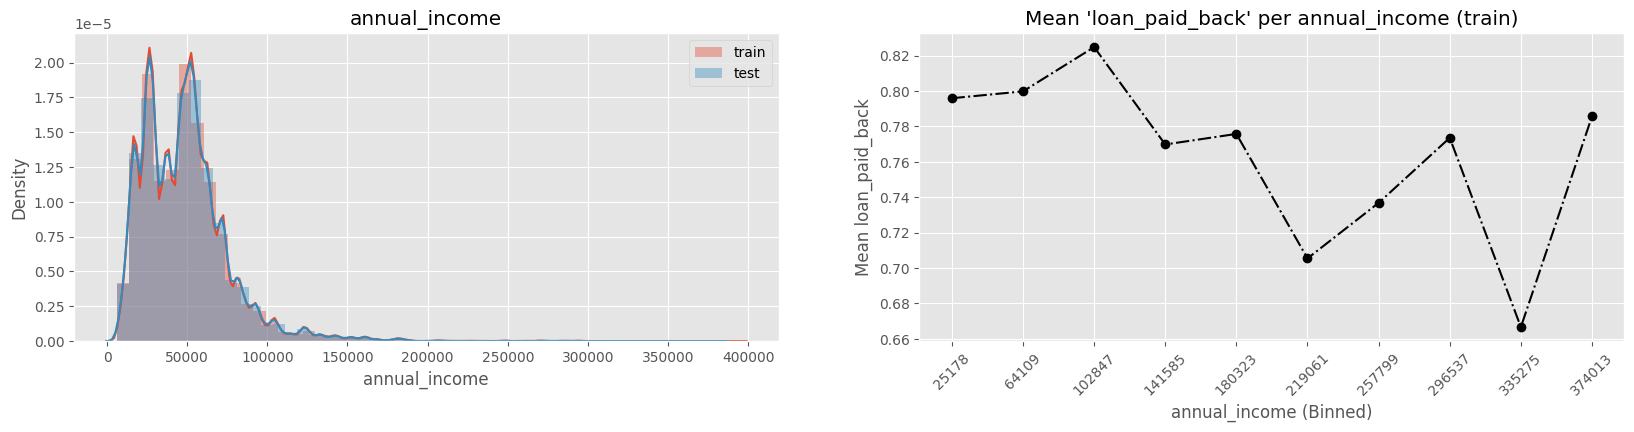

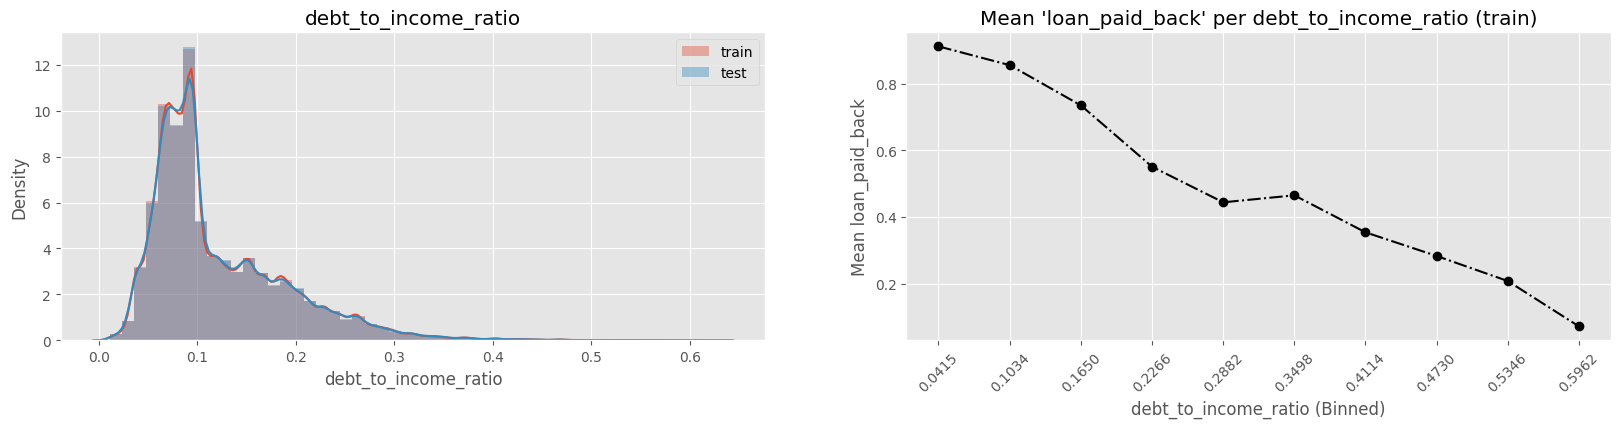

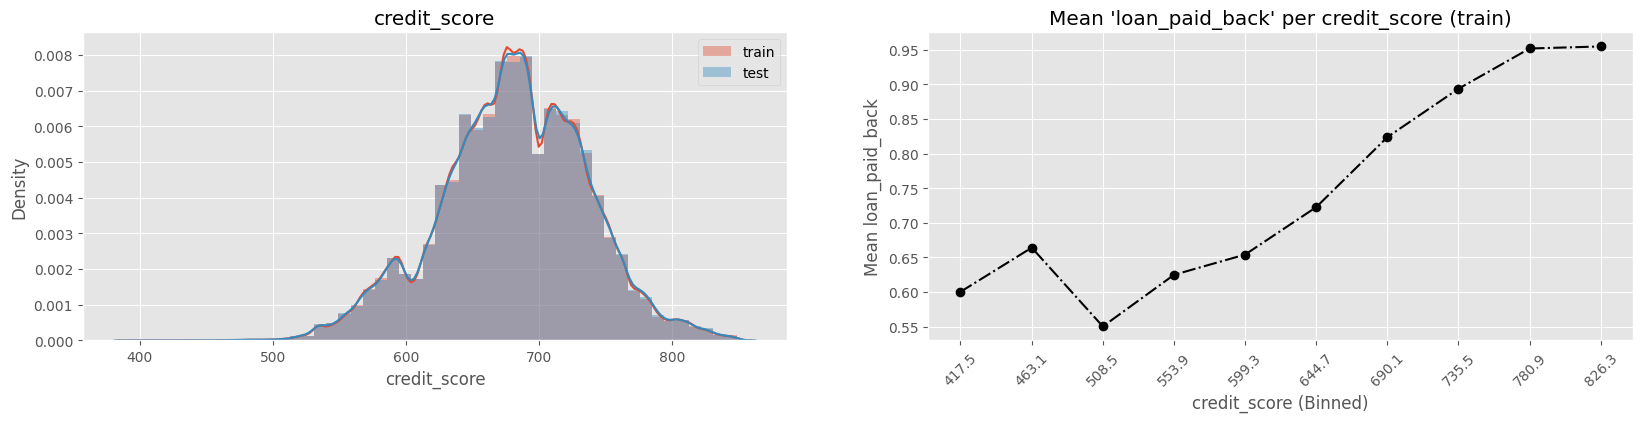

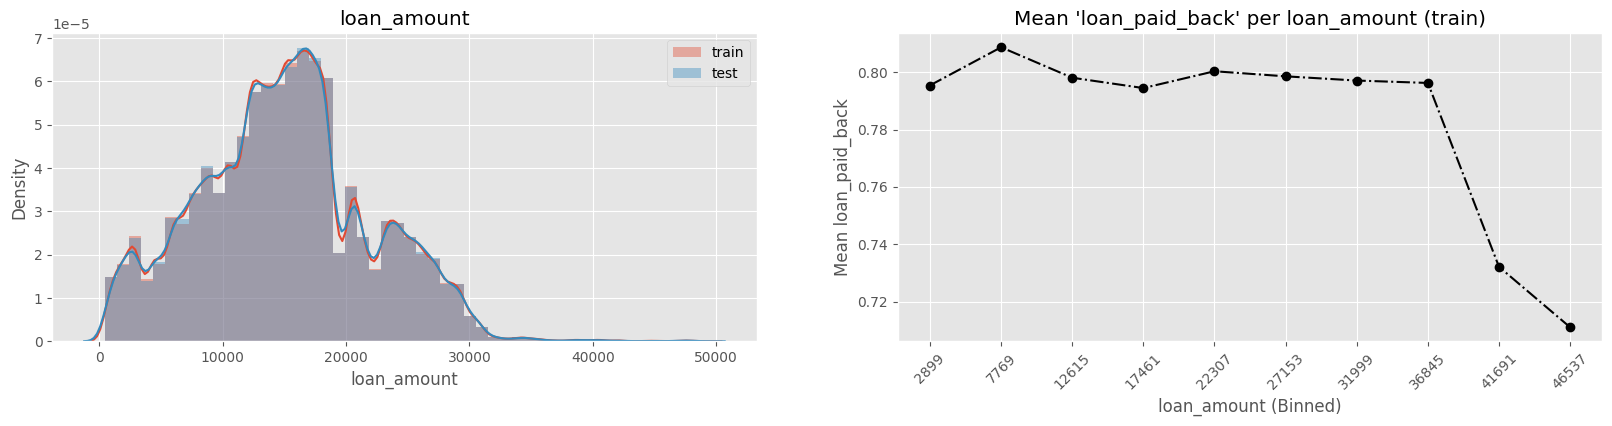

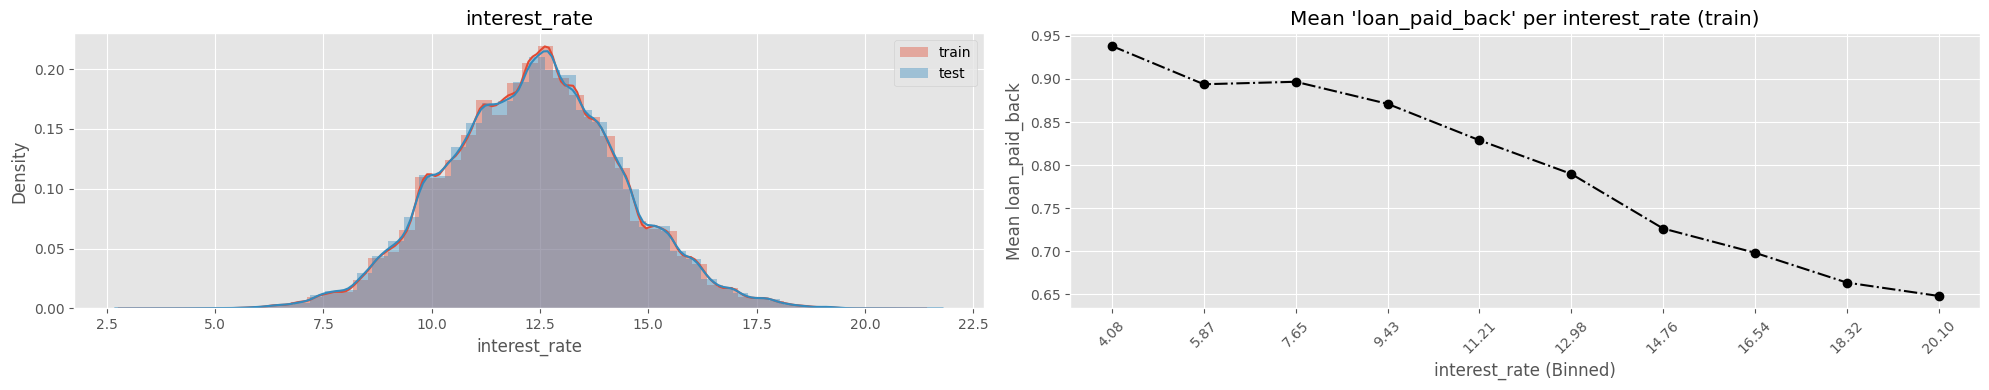

In [23]:
BINS = 10
for c in NUMS:
    # PLOT TRAIN DISTRIBUTION COMPARED WITH TEST DISTRIBUTION
    plt.figure(figsize=(20, 4))
    plt.subplot(121)
    sns.distplot(train[c], label='train',)
    sns.distplot(test[c], label='test', )
    plt.legend()
    plt.title(f"{c}")
    # PLOT TARGET RELATIONSHIP WITH BINNED FEATURES
    plt.subplot(122)
    train['bucket'], bin_edges = pd.cut(train[c], bins=BINS, retbins=True, labels=False)
    bucket_means = train.groupby('bucket')[TARGET].mean()
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_midpoints, bucket_means, marker='o', linestyle='-.', color='k')
    plt.xlabel(f'{c} (Binned)')
    plt.ylabel(f"Mean {TARGET}")
    plt.title(f"Mean '{TARGET}' per {c} (train)")
    plt.xticks(bin_midpoints, rotation=45)
    # plt.grid()

plt.tight_layout()
plt.show()

train.drop(['bucket'], axis=1, inplace=True)

### CATEGORICAL FEATURES

In [24]:
## -- Categorical Features: Counts and Mean by TARGET --
for c in CATS:
    v_counts = train[c].value_counts(dropna=False)
    v_mean = train.groupby(c)[TARGET].value_counts().unstack()
    display(v_counts.hvplot.bar(width=500, yformatter='%1.0f', bgcolor='lightgray')\
                    .opts(active_tools=["pan"], title=f"Counts of '{c}'") + \
            v_mean.hvplot.bar(width=700, yformatter='%1.0f', bgcolor='lightgray')\
                    .opts(active_tools=["pan"], title=f"{TARGET} by '{c}'"))

:Layout
   .Bars.Count :Bars   [gender]   (count)
   .Bars.I     :Bars   [gender,loan_paid_back]   (value)

:Layout
   .Bars.Count :Bars   [marital_status]   (count)
   .Bars.I     :Bars   [marital_status,loan_paid_back]   (value)

:Layout
   .Bars.Count :Bars   [education_level]   (count)
   .Bars.I     :Bars   [education_level,loan_paid_back]   (value)

:Layout
   .Bars.Count :Bars   [employment_status]   (count)
   .Bars.I     :Bars   [employment_status,loan_paid_back]   (value)

:Layout
   .Bars.Count :Bars   [loan_purpose]   (count)
   .Bars.I     :Bars   [loan_purpose,loan_paid_back]   (value)

:Layout
   .Bars.Count :Bars   [grade_subgrade]   (count)
   .Bars.I     :Bars   [grade_subgrade,loan_paid_back]   (value)

In [25]:
# def plot_heatmap(data, cat_features, name='Data'):
#     df = data.copy()
#     for c in cat_features:
#         df[c] = pd.factorize(df[c])[0]
#     CORR = df.corr('spearman')
#     plt.figure(figsize=(18, 7))
#     sns.heatmap(CORR, mask=np.triu(CORR), annot=True, cbar=False)
#     plt.title(f"Heatmap: {name}", fontsize=12)
#     plt.tight_layout()
#     plt.show()
#     del df

In [26]:
# hvplot.help('heatmap')

In [27]:
def plot_heatmap(data, cat_features, name='Data'):
    df = data.copy()
    for c in cat_features:
        df[c] = pd.factorize(df[c])[0]
    CORR = df.corr('spearman')
    display(CORR.hvplot.heatmap(
        cmap='bone',
        colorbar=False,
        height=400,
        width=800,
        rot=45,
        # robust=True,
    ).opts(active_tools=["pan"], title=f'{name}: correlation'))
    del df

In [28]:
plot_heatmap(train[FEATURES+[TARGET]], CATS, 'TRAIN')
plot_heatmap(orig[FEATURES+[TARGET]],  CATS, 'ORIGINAL')
plot_heatmap(test[FEATURES], CATS, 'TEST')

:HeatMap   [columns,index]   (value)

:HeatMap   [columns,index]   (value)

:HeatMap   [columns,index]   (value)

In [29]:
display(train.head())
train.info()

annual_income  debt_to_income_ratio  credit_score  loan_amount  \
id                                                                   
0        29367.99                 0.084           736      2528.42   
1        22108.02                 0.166           636      4593.10   
2        49566.20                 0.097           694     17005.15   
3        46858.25                 0.065           533      4682.48   
4        25496.70                 0.053           665     12184.43   

    interest_rate  gender marital_status education_level employment_status  \
id                                                                           
0           13.67  Female         Single     High School     Self-employed   
1           12.92    Male        Married        Master's          Employed   
2            9.76    Male         Single     High School          Employed   
3           16.10  Female         Single     High School          Employed   
4           10.21    Male        Married     High School          Employed   

          loan_purpose grade_subgrade  loan_paid_back  
id                                                     
0                Other             C3             1.0  
1   Debt consolidation             D3             0.0  
2   Debt consolidation             C5             1.0  
3   Debt consolidation             F1             1.0  
4                Other             D1             1.0

<class 'pandas.core.frame.DataFrame'>
Index: 593994 entries, 0 to 593993
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   annual_income         593994 non-null  float64
 1   debt_to_income_ratio  593994 non-null  float64
 2   credit_score          593994 non-null  int64  
 3   loan_amount           593994 non-null  float64
 4   interest_rate         593994 non-null  float64
 5   gender                593994 non-null  object 
 6   marital_status        593994 non-null  object 
 7   education_level       593994 non-null  object 
 8   employment_status     593994 non-null  object 
 9   loan_purpose          593994 non-null  object 
 10  grade_subgrade        593994 non-null  object 
 11  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 58.9+ MB


### FEATURE ENGINEERING

In [30]:
STATS = ['mean', 'count', 'nunique']  # stats to compute
ORIG = []

print(f"Merging {len(FEATURES)} features: ", end="")

for feat in FEATURES:
    print(f"{feat}, ", end="")

    # compute aggregations on orig
    agg = orig.groupby(feat)[TARGET].agg(STATS)
    new_cols = [f'OTE_{feat}_{s.upper()}' for s in STATS]
    agg.columns = new_cols
    agg = agg.reset_index() 

    # merge into train and test
    train = train.merge(agg, on=feat, how='left')
    test  = test.merge(agg, on=feat, how='left')

    # optionally fill NaNs (choose a sensible fill)
    # e.g., fill count with 0, nunique with 0, mean with global mean
    # global_mean = orig[TARGET].mean()
    # train[new_cols] = train[new_cols].fillna({'OTE_feat_MEAN': global_mean, 'OTE_feat_COUNT': 0, ...})
    # simpler: fill all with -1 (or use per-column logic)
    # train[new_cols] = train[new_cols].fillna(-1)
    # test[new_cols]  = test[new_cols].fillna(-1)

    ORIG.extend(new_cols)

# After all merges, drop columns that are constant in both train and test (or whichever criterion you prefer)
to_drop = []
for col in list(ORIG):
    # check column exists (safety) and whether it's constant (nunique < 2) in both datasets
    n_train = train[col].nunique() if col in train.columns else 0
    n_test  = test[col].nunique()  if col in test.columns  else 0
    if (n_train < 2) and (n_test < 2):
        to_drop.append(col)

if to_drop:
    train = train.drop(columns=to_drop)
    test  = test.drop(columns=to_drop)
    ORIG = [c for c in ORIG if c not in to_drop]

print()
print(f"\n##### Total features merged: {len(ORIG)}")

Merging 11 features: annual_income, debt_to_income_ratio, credit_score, loan_amount, interest_rate, gender, marital_status, education_level, employment_status, loan_purpose, grade_subgrade, 

##### Total features merged: 27


In [31]:
# ## Fill NaNs with appropriate imputations --
# for c in ORIG:
#     if "MEAN" in c:
#         train[c] = train[c].fillna(orig[TARGET].mean())
#         test[c]  = test[c].fillna(orig[TARGET].mean())
#     elif "COUNT" in c:
#         train[c] = train[c].fillna(orig[c].mode())
#         test[c]  = test[c].fillna(orig[c].mode())
        
# print(f"NaNs present: {train.isna().sum().sum()}")

In [32]:
## -- Factorize using combined data --
for c in CATS:
    combined = pd.concat([train[c], test[c]], ignore_index=True)
    combined = combined.factorize()[0]
    train[c] = combined[:len(train)].astype('int8')
    test[c]  = combined[len(train):].astype('int8')

print(f"✅ Features encoded: {len(CATS)}")
train.shape, test.shape

✅ Features encoded: 6


((593994, 39), (254569, 38))

In [33]:
display(train.head())
train.info()

annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0       29367.99                 0.084           736      2528.42   
1       22108.02                 0.166           636      4593.10   
2       49566.20                 0.097           694     17005.15   
3       46858.25                 0.065           533      4682.48   
4       25496.70                 0.053           665     12184.43   

   interest_rate  gender  marital_status  education_level  employment_status  \
0          13.67       0               0                0                  0   
1          12.92       1               1                1                  1   
2           9.76       1               0                0                  1   
3          16.10       0               0                0                  1   
4          10.21       1               1                0                  1   

   loan_purpose  grade_subgrade  loan_paid_back  OTE_annual_income_MEAN  \
0             0               0             1.0                     0.0   
1             1               1             0.0                     1.0   
2             1               2             1.0                     NaN   
3             1               3             1.0                     NaN   
4             0               4             1.0                     1.0   

   OTE_annual_income_COUNT  OTE_annual_income_NUNIQUE  \
0                      1.0                        1.0   
1                      1.0                        1.0   
2                      NaN                        NaN   
3                      NaN                        NaN   
4                      1.0                        1.0   

   OTE_debt_to_income_ratio_MEAN  OTE_debt_to_income_ratio_COUNT  \
0                       0.884615                            78.0   
1                       0.765432                            81.0   
2                       0.923077                            91.0   
3                       0.925373                            67.0   
4                       0.943662                            71.0   

   OTE_debt_to_income_ratio_NUNIQUE  OTE_credit_score_MEAN  \
0                               2.0               0.862069   
1                               2.0               0.649485   
2                               2.0               0.825243   
3                               2.0               0.846154   
4                               2.0               0.843750   

   OTE_credit_score_COUNT  OTE_credit_score_NUNIQUE  OTE_loan_amount_MEAN  \
0                    87.0                       2.0                   1.0   
1                    97.0                       2.0                   1.0   
2                   103.0                       2.0                   1.0   
3                    13.0                       2.0                   1.0   
4                    96.0                       2.0                   0.0   

   OTE_loan_amount_COUNT  OTE_loan_amount_NUNIQUE  OTE_interest_rate_MEAN  \
0                    1.0                      1.0                0.800000   
1                    1.0                      1.0                0.560000   
2                    1.0                      1.0                0.869565   
3                    1.0                      1.0                0.600000   
4                    1.0                      1.0                0.740741   

   OTE_interest_rate_COUNT  OTE_interest_rate_NUNIQUE  OTE_gender_MEAN  \
0                     30.0                        2.0         0.802472   
1                     25.0                        2.0         0.797504   
2                     23.0                        2.0         0.797504   
3                     10.0                        2.0         0.802472   
4                     27.0                        2.0         0.797504   

   OTE_gender_COUNT  OTE_marital_status_MEAN  OTE_marital_status_COUNT  \
0             10034                 0.799579                      9031   
1           

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 39 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   annual_income                     593994 non-null  float64
 1   debt_to_income_ratio              593994 non-null  float64
 2   credit_score                      593994 non-null  int64  
 3   loan_amount                       593994 non-null  float64
 4   interest_rate                     593994 non-null  float64
 5   gender                            593994 non-null  int8   
 6   marital_status                    593994 non-null  int8   
 7   education_level                   593994 non-null  int8   
 8   employment_status                 593994 non-null  int8   
 9   loan_purpose                      593994 non-null  int8   
 10  grade_subgrade                    593994 non-null  int8   
 11  loan_paid_back                    593994 non-null  f

### ML TRAINING

In [34]:
## -- Define Models --
models = {
    'XGB': xgb.XGBClassifier(
        eval_metric='auc',
        enable_categorical=True,
        random_state=SEED,
        n_jobs=-1,
        verbosity=0,
    ),
    'LGB': lgb.LGBMClassifier(
        metric='auc',
        categorical_feature=CATS,
        random_state=SEED,
        n_jobs=-1,
        verbose=-1,
    ),
    'CAT': cgb.CatBoostClassifier(
        eval_metric='AUC',
        cat_features=CATS,
        allow_writing_files=False,
        random_state=SEED,
        thread_count=-1,
        verbose=0,
    ),
}

print(f"Training {len(models)} model:  ", end="")
print(list(models.keys()))

Training 3 model:  ['XGB', 'LGB', 'CAT']


ℹ️ Device: CPU 4 cores


  0%|          | 0/3 [00:00<?, ?it/s]


Training model: XGB
	Fold 1 AUC: 0.924140
	Fold 2 AUC: 0.924031
	Fold 3 AUC: 0.922650
	Fold 4 AUC: 0.923822
	Fold 5 AUC: 0.923141
|----------------------------------------------------
| Overall AUC: 0.923550
| Average AUC: 0.923557 ± 0.000571
| Training Time: 0.99 mins


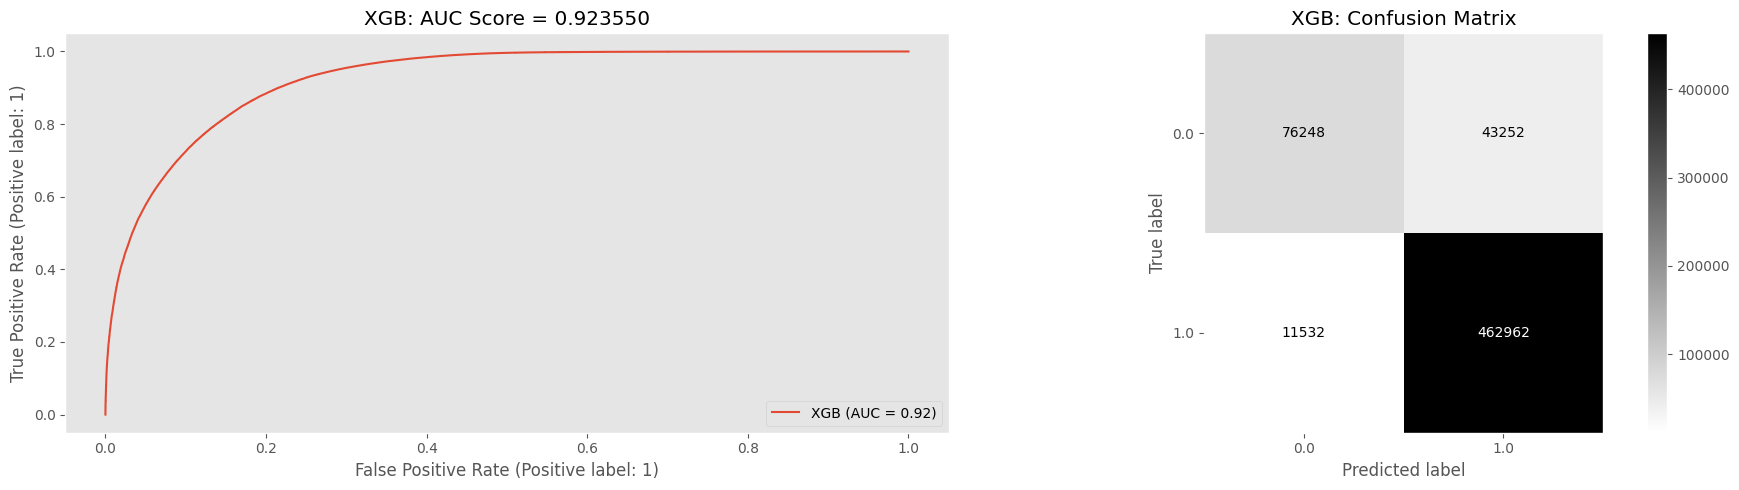


Training model: LGB
	Fold 1 AUC: 0.924356
	Fold 2 AUC: 0.924803
	Fold 3 AUC: 0.923043
	Fold 4 AUC: 0.924024
	Fold 5 AUC: 0.923441
|----------------------------------------------------
| Overall AUC: 0.923927
| Average AUC: 0.923933 ± 0.000629
| Training Time: 0.55 mins


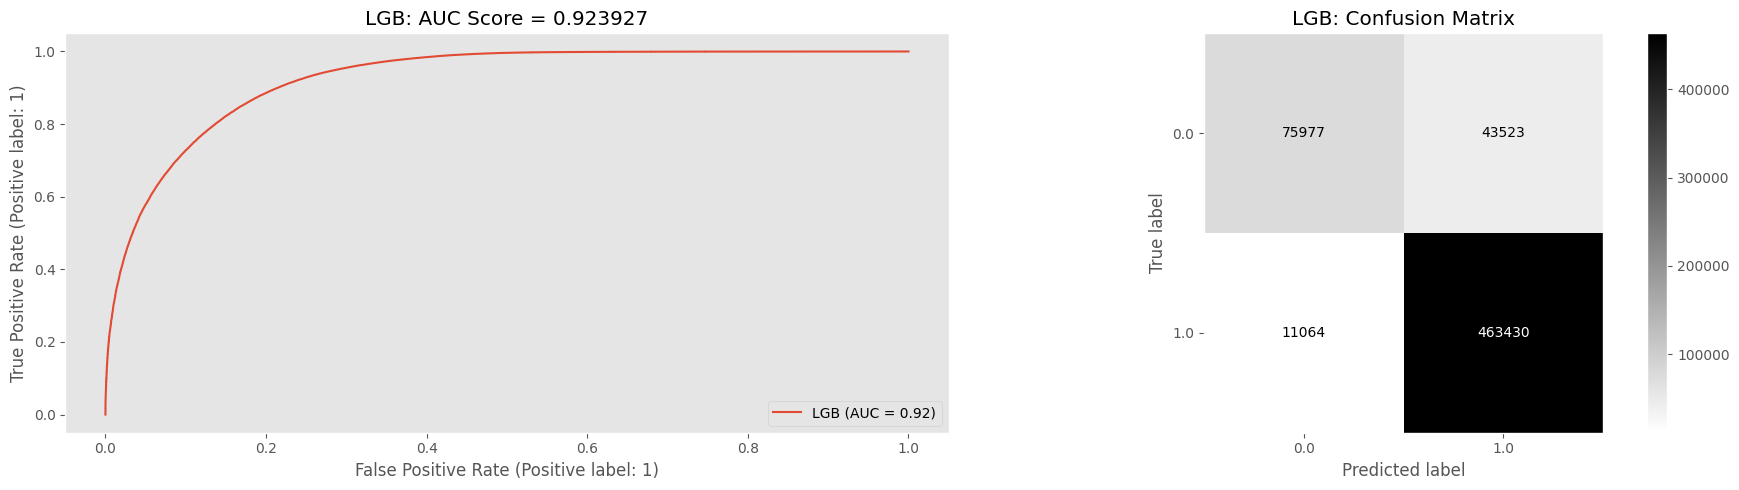


Training model: CAT
	Fold 1 AUC: 0.925138
	Fold 2 AUC: 0.925769
	Fold 3 AUC: 0.923766
	Fold 4 AUC: 0.924888
	Fold 5 AUC: 0.924552
|----------------------------------------------------
| Overall AUC: 0.924818
| Average AUC: 0.924823 ± 0.000662
| Training Time: 31.74 mins


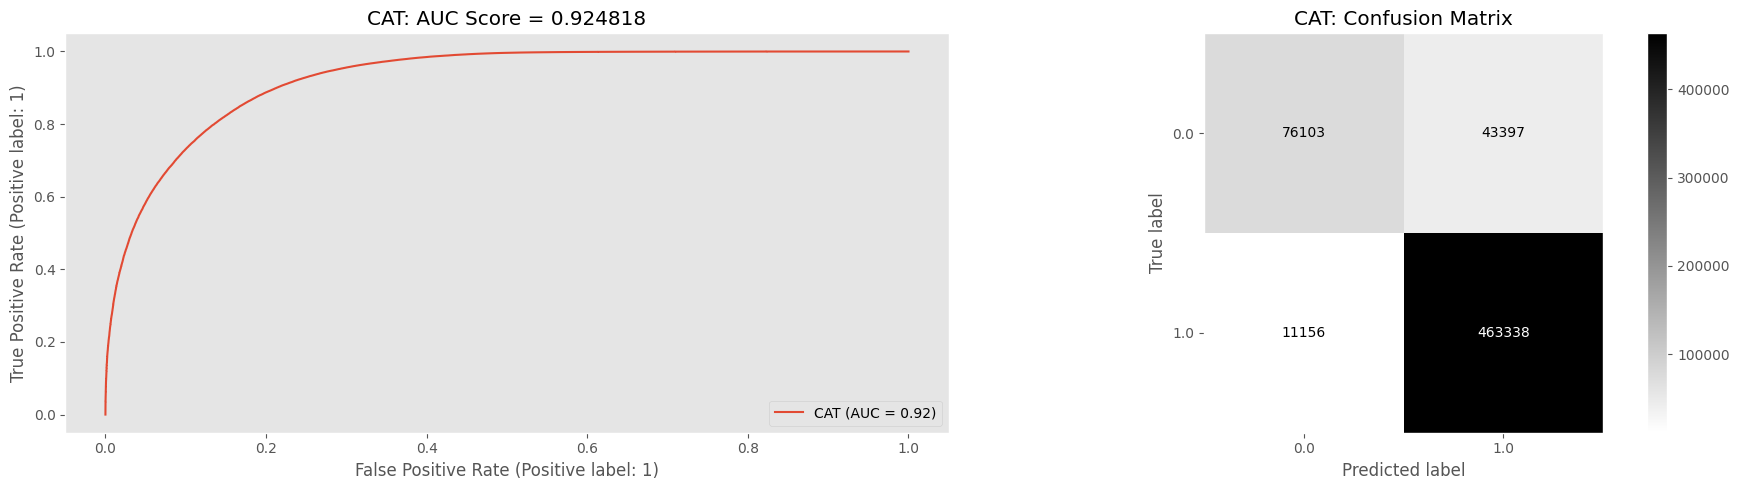

In [35]:
## -- DEFINE TRAINING PARAMETERS --
if torch.cuda.is_available():
    print(f"ℹ️ Device GPU: {torch.cuda.get_device_name(0)}")
    print(f"ℹ️ No. of CPU: {os.cpu_count()} cores")
else:
    print(f"ℹ️ Device: CPU {os.cpu_count()} cores")
## -----------------------------------------------------------------------
## -- Split data --
X = train[FEATURES+ORIG].copy()
y = train[TARGET].copy()
X_test = test[FEATURES+ORIG].copy()

oof_final = pd.DataFrame()
test_final = pd.DataFrame()

MODELS_FIT = {}
FOLDS      = 5
kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

## -- Initiate Training -- 
## -----------------------------------------------------------------------
for i, (name, model) in tqdm(enumerate(models.items()), total=len(models)):
    print(f"\n{COLOR}Training model: {name}{RESET}")
    
    tik = time()

    oof_preds  = np.zeros(len(X))
    test_preds = np.zeros(len(test))
    fold_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        X_train[CATS] = X_train[CATS].astype("category")
        X_val[CATS] = X_val[CATS].astype("category")
        X_test[CATS] = X_test[CATS].astype("category")
            
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        oof_preds[val_idx] = y_pred

        predictions = model.predict_proba(X_test)[:, 1]
        test_preds += predictions / FOLDS

        score = roc_auc_score(y_val, y_pred)
        fold_scores.append(score)

        print(f"{COLOR}\tFold {fold+1} AUC: {score:.6f}{RESET}")

    tok = time()
    tiktok = (tok-tik)/60
    
    ## -- After all folds --
    overall_AUC = roc_auc_score(y, oof_preds)
    print(f"|{'-'*52}{COLOR}")
    print(f"| Overall AUC: {overall_AUC:.6f}")
    print(f"| Average AUC: {np.mean(fold_scores):.6f} ± {np.std(fold_scores):.6f}")
    print(f"| Training Time: {tiktok:.2f} mins{RESET}")
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    # Left: ROC curve
    RocCurveDisplay.from_predictions(y, oof_preds, name=name, ax=axes[0])
    axes[0].set_title(f"{name}: AUC Score = {overall_AUC:.6f}")
    axes[0].grid(False)
    
    # Right: Confusion matrix (threshold = 0.5)
    pred_labels = (oof_preds >= 0.5).astype(int)
    disp = ConfusionMatrixDisplay.from_predictions(y, pred_labels, cmap='binary', ax=axes[1])
    axes[1].set_title(f"{name}: Confusion Matrix")
    axes[1].grid(False)
    
    plt.tight_layout()
    plt.show()

    oof_final[name]  = oof_preds
    test_final[name] = test_preds
    MODELS_FIT[name] = model

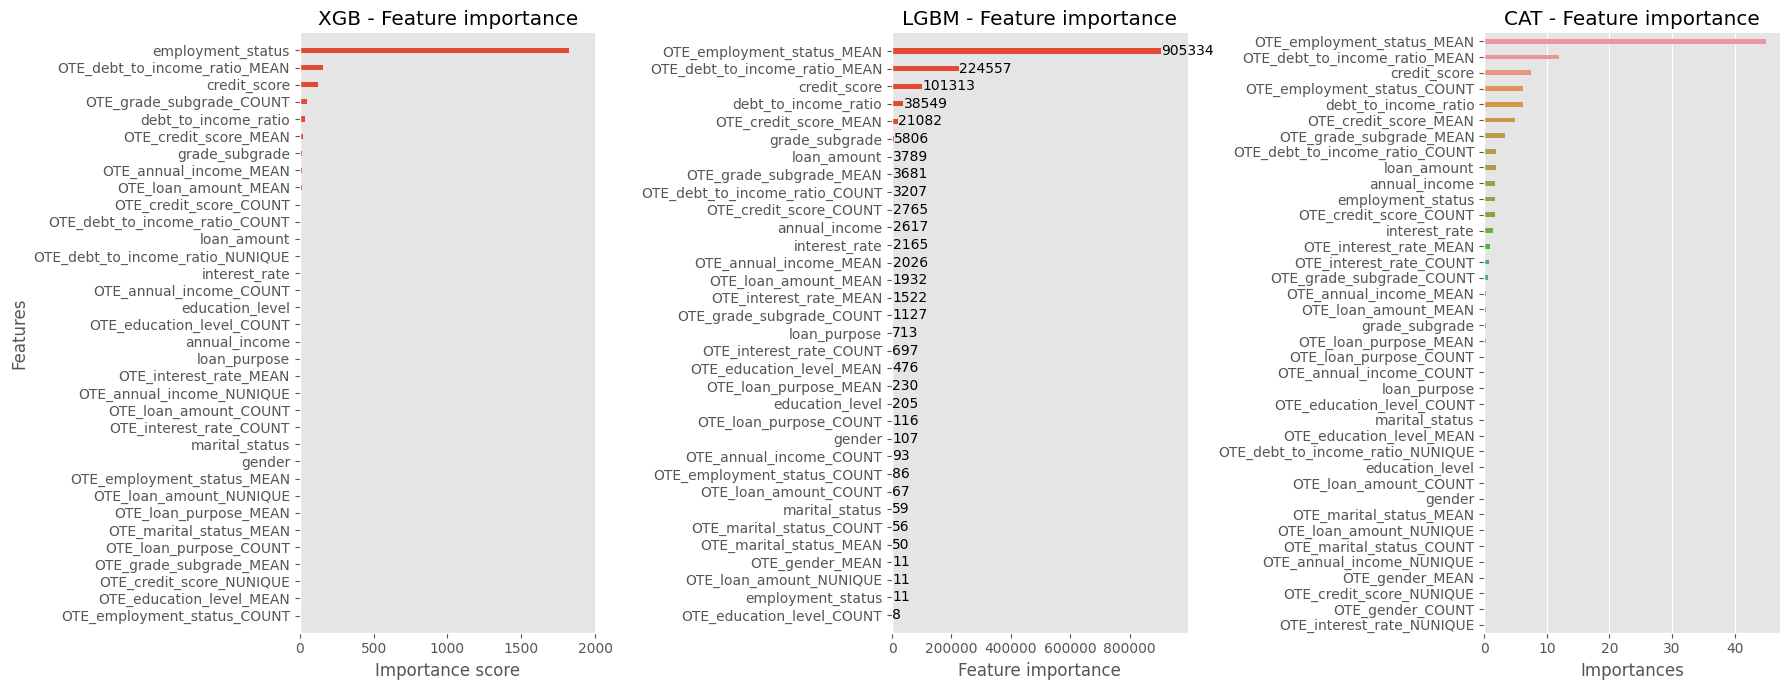

In [36]:
## -- PLOT FEATURES IMPORTANCES -- 
fig, axs = plt.subplots(1, 3, figsize=(18, 7))

## -- XGBoost -- 
xgb.plot_importance(MODELS_FIT['XGB'], importance_type='gain',
                    ax=axs[0], grid=False, height=.3, show_values=False,
                    title="XGB - Feature importance")

## -- LightGBM -- 
lgb.plot_importance(MODELS_FIT['LGB'], importance_type='gain',
                    ax=axs[1], grid=False, height=.3, precision=0,
                    title="LGBM - Feature importance")
axs[1].set_ylabel("")

## -- CatBoost -- 
cat_imp_df = MODELS_FIT['CAT'].get_feature_importance(prettified=True)
sns.barplot(data=cat_imp_df, x='Importances', y='Feature Id', width=.3, ax=axs[2])
axs[2].set_title('CAT - Feature importance')
axs[2].set_ylabel("")

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show() 

In [37]:
# ## -- Plot SHAP values --
# MAX = 20
# for i, (name, model) in enumerate(MODELS_FIT.items()):
#     if name in ['XGB', 'LGB']: # -> plot only xgboost & lightgbm
#         fig, axs = plt.subplots(1, 2, figsize=(20, 8))
#         # Shap Explainer
#         explainer = shap.TreeExplainer(model)
#         explanation = explainer(X_val)
#         # Bar plot 
#         shap.plots.bar(explanation[0], max_display=MAX, ax=axs[0], show=False)
#         axs[0].set_title("SHAP Bar Plot")
#         # Beeswarm plot
#         shap.plots.beeswarm(explanation, max_display=MAX, ax=axs[1], show=False,
#                             order=explanation.abs.max(0), # <-most impactful feature
#                             color_bar=False, plot_size=None,)
#         axs[1].set_title("SHAP Beeswarm Plot") 
#         fig.suptitle(f"- {name}: SHAP Feature Importances -", fontsize=15, fontweight='semibold')
#         fig.tight_layout(pad=1.5) 
#         plt.show()
#         print()

In [38]:
## -- Predictions/OOF of models --
display(test_final.head())
display(oof_final.head())

XGB       LGB       CAT
0  0.937203  0.928606  0.949390
1  0.970386  0.967994  0.968712
2  0.506064  0.449998  0.428101
3  0.898276  0.916701  0.907651
4  0.961938  0.955881  0.961783

XGB       LGB       CAT
0  0.988832  0.983473  0.981766
1  0.538059  0.559552  0.433326
2  0.935762  0.943574  0.930883
3  0.762878  0.833760  0.788740
4  0.971312  0.968295  0.975301

### SUBMISSION

In [39]:
## -- Create Submissions for each model --
for c in test_final.columns:
    oof_final[[c]].to_parquet(f"{c}_base_oof.parquet", index=False)
    test_final[[c]].to_parquet(f"{c}_base_pred.parquet", index=False)
    print(f"{COLOR}-> {c} OOF & PREDICTION files saved!")

-> XGB OOF & PREDICTION files saved!
-> LGB OOF & PREDICTION files saved!
-> CAT OOF & PREDICTION files saved!


In [40]:
## -- Create Submissions for each model --
for c in test_final.columns:
    submit[TARGET] = test_final[c].values
    submit.to_csv(f"submit_{c}_base.csv", index=False)
    print(f"{COLOR}-> submit_{c}_base.csv file saved!")

-> submit_XGB_base.csv file saved!
-> submit_LGB_base.csv file saved!
-> submit_CAT_base.csv file saved!
